# Problem 2


## dataset.py

[0.50161345 0.45612671 0.3824407 ] [0.24617303 0.23615181 0.23905821]


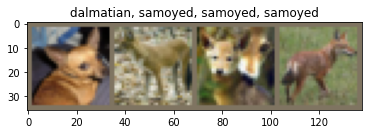

In [1]:
# EECS 545 Fall 2021
import os
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms


class DogDataset:
    """
    Dog Dataset.
    """
    def __init__(self, batch_size=4, dataset_path='data/images/dogs', if_resize=True):
        self.batch_size = batch_size
        self.dataset_path = dataset_path
        self.if_resize = if_resize
        self.train_dataset = self.get_train_numpy()
        self.x_mean, self.x_std = self.compute_train_statistics()
        self.transform = self.get_transforms()
        self.train_loader, self.val_loader = self.get_dataloaders()

    def get_train_numpy(self):
        train_dataset = torchvision.datasets.ImageFolder(os.path.join(self.dataset_path, 'train'))
        train_x = np.zeros((len(train_dataset), 224, 224, 3))
        # train_x = np.zeros((len(train_dataset), 64, 64, 3))
        for i, (img, _) in enumerate(train_dataset):
            train_x[i] = img
        return train_x / 255.0

    def compute_train_statistics(self):
        # TODO (part a): compute per-channel mean and std with respect to self.train_dataset
        x_mean = np.mean(self.train_dataset,axis=(0,1,2)) # per-channel mean
        x_std = np.std(self.train_dataset,axis=(0,1,2)) # per-channel std
        return x_mean, x_std

    def get_transforms(self):
        if self.if_resize:
            # TODO (part a): fill in the data transforms
            transform_list = [
                # resize the image to 32x32x3
                transforms.Resize((32,32)),
                # convert image to PyTorch tensor
                transforms.ToTensor(),
                # normalize the image (use self.x_mean and self.x_std)
                transforms.Normalize(self.x_mean,self.x_std)
            ]
        else: 
            # TODO (part f): fill in the data transforms
            # Note: Only change from part a) is there is no need to resize the image 
                transform_list = [
                # convert image to PyTorch tensor
                transforms.ToTensor(),
                # normalize the image (use self.x_mean and self.x_std)
                transforms.Normalize(self.x_mean,self.x_std)
            ]
        transform = transforms.Compose(transform_list)
        return transform

    def get_dataloaders(self):
        # train set
        train_set = torchvision.datasets.ImageFolder(os.path.join(self.dataset_path, 'train'), transform=self.transform)
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=self.batch_size, shuffle=True)

        # validation set
        val_set = torchvision.datasets.ImageFolder(os.path.join(self.dataset_path, 'val'), transform=self.transform)
        val_loader = torch.utils.data.DataLoader(val_set, batch_size=self.batch_size, shuffle=False)

        return train_loader, val_loader

    def plot_image(self, image, label):
        image = np.transpose(image.numpy(), (1, 2, 0))
        image = image * self.x_std.reshape(1, 1, 3) + self.x_mean.reshape(1, 1, 3)  # un-normalize
        plt.title(label)
        plt.imshow((image*255).astype('uint8'))
        plt.show()

    def get_semantic_label(self, label):
        mapping = {'chihuahua': 0, 'dalmatian': 1, 'golden_retriever': 2, 'samoyed': 3, 'siberian_husky': 4}
        reverse_mapping = {v: k for k, v in mapping.items()}
        return reverse_mapping[label]


class DogCatDataset:
    """
    Cat vs. Dog Dataset.
    """
    def __init__(self, batch_size=4, dataset_path='data/images/dogs_vs_cats'):
        self.batch_size = batch_size
        self.dataset_path = dataset_path
        self.transform = self.get_transforms()
        self.train_loader, self.val_loader = self.get_dataloaders()

    def get_transforms(self):
        # TODO (part g): fill in the data transforms
        transform_list = [
            # resize the image to 256x256x3
            transforms.Resize((256,256)),
            # crop the image at the center of size 224x224x3
            transforms.CenterCrop((224,224)),
            # convert image to PyTorch tensor
            transforms.ToTensor(),
            # normalize the image
            transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
        ]
        transform = transforms.Compose(transform_list)
        return transform

    def get_dataloaders(self):
        # train set
        train_set = torchvision.datasets.ImageFolder(os.path.join(self.dataset_path, 'train'), transform=self.transform)
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=self.batch_size, shuffle=True)

        # validation set
        val_set = torchvision.datasets.ImageFolder(os.path.join(self.dataset_path, 'val'), transform=self.transform)
        val_loader = torch.utils.data.DataLoader(val_set, batch_size=self.batch_size, shuffle=False)

        return train_loader, val_loader


if __name__ == '__main__':
    dataset = DogDataset()
    print(dataset.x_mean, dataset.x_std)
    images, labels = iter(dataset.train_loader).next()
    dataset.plot_image(
        torchvision.utils.make_grid(images),
        ', '.join([dataset.get_semantic_label(label.item()) for label in labels])
    )


## model.py

In [3]:
# EECS 545 Fall 2021
import math
# from typing_extensions import TypeVarTuple
import torch.nn as nn
import torch.nn.functional as F


class CNN(nn.Module):
    """
    Convolutional Neural Network.
    """
    def __init__(self):
        super().__init__()

        # TODO (part c): define layers
        self.conv1 = nn.Conv2d(3, 16, 5, stride=2, padding=2)  # convolutional layer 1
        self.conv2 = nn.Conv2d(16, 32, 5, stride=2, padding=2) # convolutional layer 2
        self.conv3 = nn.Conv2d(32, 64, 5, stride=2, padding=2) # convolutional layer 3
        self.conv4 = nn.Conv2d(64, 128, 5, stride=2, padding=2) # convolutional layer 4
        self.fc1 = nn.Linear(128*2*2, 64, bias=True) # fully connected layer 1
        self.fc2 = nn.Linear(64, 5, bias=True) # fully connected layer 2 (output layer)

        self.init_weights()

    def init_weights(self):
        for conv in [self.conv1, self.conv2, self.conv3, self.conv4]:
            C_in = conv.weight.size(1)
            nn.init.normal_(conv.weight, 0.0, 1/math.sqrt(5 * 2.5 * C_in))
            nn.init.constant_(conv.bias, 0.0)

        # TODO (part c): initialize parameters for fully connected layers
        nn.init.normal_(self.fc1.weight, 0.0, 1/math.sqrt(256))
        nn.init.constant_(self.fc1.bias, 0.0)
        nn.init.normal_(self.fc2.weight, 0.0, 1/math.sqrt(32))
        nn.init.constant_(self.fc2.bias, 0.0)

    def forward(self, x):
        N, C, H, W = x.shape

        # TODO (part c): forward pass of image through the network
        z = F.relu(self.conv1(x))
        z = F.relu(self.conv2(z))
        z = F.relu(self.conv3(z))
        z = F.relu(self.conv4(z))
        z = z.view(z.size(0),-1)
        z = F.relu(self.fc1(z))
        z = self.fc2(z)
        return z    


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


if __name__ == '__main__':
    from dataset import DogDataset
    net = CNN()
    print(net)
    print('Number of CNN parameters: {}'.format(count_parameters(net)))
    dataset = DogDataset()
    images, labels = iter(dataset.train_loader).next()
    print('Size of model output:', net(images).size())

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (fc1): Linear(in_features=512, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=5, bias=True)
)
Number of CNN parameters: 303397
Size of model output: torch.Size([4, 5])


## train.py

Loading model...
Which epoch to load from? Choose from epochs below:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Enter 0 to train from scratch.
>> 10
Loading from checkpoint checkpoints/cnn/epoch=10.checkpoint.pth.tar
=> Successfully restored checkpoint (trained for 10 epochs)
Setting up interactive graph...
Epoch 10
	Validation Loss: 2.3131151782372634
	Validation Accuracy: 0.48717948717948717
	Train Loss: 0.007707070170436054
	Train Accuracy: 1.0


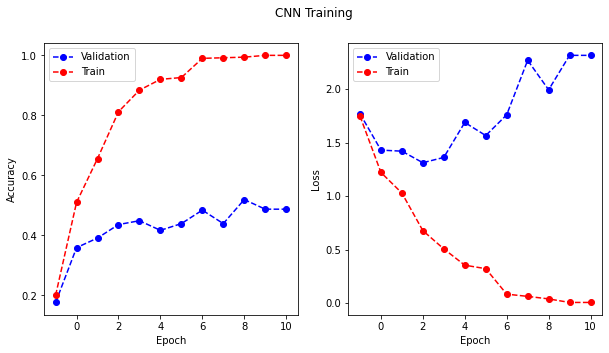

Finished Training


<Figure size 432x288 with 0 Axes>

In [4]:
# EECS 545 Fall 2021
import torch
import numpy as np
import random

# from torch._C import FloatTensor
import checkpoint
from dataset import DogDataset, DogCatDataset
from model import CNN
from plot import Plotter

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

def predictions(logits):
    """
    Compute the predictions from the model.
    Inputs:
        - logits: output of our model based on some input, tensor with shape=(batch_size, num_classes)
    Returns:
        - pred: predictions of our model, tensor with shape=(batch_size)
    """
    # TODO (part d): compute the predictions
    pred = torch.argmax(logits, dim=1)
    return pred


def accuracy(y_true, y_pred):
    """
    Compute the accuracy given true and predicted labels.
    Inputs:
        - y_true: true labels, tensor with shape=(num_examples)
        - y_pred: predicted labels, tensor with shape=(num_examples)
    Returns:
        - acc: accuracy, float
    """
    # TODO (part d): compute the accuracy
    num_examples = y_true.shape[0]
    acc = np.sum(y_true.numpy()==y_pred.numpy())/num_examples
    return acc


def _train_epoch(train_loader, model, criterion, optimizer):
    """
    Train the model for one iteration through the train set.
    """
    for i, (X, y) in enumerate(train_loader):
        # clear parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()


def _evaluate_epoch(plotter, train_loader, val_loader, model, criterion, epoch):
    """
    Evaluates the model on the train and validation set.
    """
    stat = []
    for data_loader in [val_loader, train_loader]:
        y_true, y_pred, running_loss = evaluate_loop(data_loader, model, criterion)
        total_loss = np.sum(running_loss) / y_true.size(0)
        total_acc = accuracy(y_true, y_pred)
        stat += [total_acc, total_loss]
    plotter.stats.append(stat)
    plotter.log_cnn_training(epoch)
    plotter.update_cnn_training_plot(epoch)


def evaluate_loop(data_loader, model, criterion=None):
    model.eval()
    y_true, y_pred, running_loss = [], [], []
    for X, y in data_loader:
        with torch.no_grad():
            output = model(X)
            predicted = predictions(output.data)
            y_true.append(y)
            y_pred.append(predicted)
            if criterion is not None:
                running_loss.append(criterion(output, y).item() * X.size(0))
    model.train()
    y_true, y_pred = torch.cat(y_true), torch.cat(y_pred)
    return y_true, y_pred, running_loss


def train(config, dataset, model):
    # Data loaders
    train_loader, val_loader = dataset.train_loader, dataset.val_loader

    if 'use_weighted' not in config:
        # TODO (part d): define loss function
        criterion = torch.nn.CrossEntropyLoss()
    else:
        # TODO (part h): define weighted loss function
        criterion = torch.nn.CrossEntropyLoss(weight=torch.FloatTensor([1,20]))
        
    # TODO (part d): define optimizer
    learning_rate = config['learning_rate']
    momentum = config['momentum']
    optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate,momentum=momentum)

    # Attempts to restore the latest checkpoint if exists
    print('Loading model...')
    force = config['ckpt_force'] if 'ckpt_force' in config else False
    model, start_epoch, stats = checkpoint.restore_checkpoint(model, config['ckpt_path'], force=force)

    # Create plotter
    plot_name = config['plot_name'] if 'plot_name' in config else 'CNN'
    plotter = Plotter(stats, plot_name)

    # Evaluate the model
    _evaluate_epoch(plotter, train_loader, val_loader, model, criterion, start_epoch)

    # Loop over the entire dataset multiple times
    for epoch in range(start_epoch, config['num_epoch']):
        # Train model on training set
        _train_epoch(train_loader, model, criterion, optimizer)

        # Evaluate model on training and validation set
        _evaluate_epoch(plotter, train_loader, val_loader, model, criterion, epoch + 1)

        # Save model parameters
        checkpoint.save_checkpoint(model, epoch + 1, config['ckpt_path'], plotter.stats)

    print('Finished Training')

    # Save figure and keep plot open
    plotter.save_cnn_training_plot()
    plotter.hold_training_plot()


if __name__ == '__main__':
    # define config parameters for training
    config = {
        'dataset_path': 'data/images/dogs',
        'batch_size': 4,
        'if_resize': True,             # If resize of the image is needed 
        'ckpt_path': 'checkpoints/cnn',  # directory to save our model checkpoints
        'num_epoch': 10,                 # number of epochs for training
        'learning_rate': 1e-3,           # learning rate
        'momentum': 0.9,                  # momentum 
    }
    # create dataset
    dataset = DogDataset(config['batch_size'], config['dataset_path'],config['if_resize'])
    # create model
    model = CNN()
    # train our model on dataset
    train(config, dataset, model)

## transfer.py

Loading model...
Which epoch to load from? Choose from epochs below:
[0, 1, 2, 3, 4, 5]
Enter 0 to train from scratch.
>> 5
Loading from checkpoint checkpoints/transfer/epoch=5.checkpoint.pth.tar
=> Successfully restored checkpoint (trained for 5 epochs)
Setting up interactive graph...
Epoch 5
	Validation Loss: 0.18001348892740238
	Validation Accuracy: 0.9358974358974359
	Train Loss: 0.11598092106450349
	Train Accuracy: 0.956


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


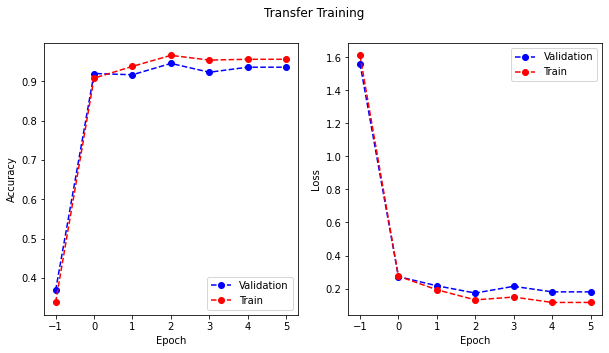

Finished Training


<Figure size 432x288 with 0 Axes>

In [5]:
# EECS 545 Fall 2021
import torch
import torchvision.models as models
from dataset import DogDataset
from train import train


def load_pretrained(num_classes=5):
    """
    Load a ResNet-18 model from `torchvision.models` with pre-trained weights. Freeze all the parameters besides the
    final layer by setting the flag `requires_grad` for each parameter to False. Replace the final fully connected layer
    with another fully connected layer with `num_classes` many output units.
    Inputs:
        - num_classes: int
    Returns:
        - model: PyTorch model
    """
    # TODO (part f): load a pre-trained ResNet-18 model
    resnet18 = models.resnet18(pretrained=True)
    for param in resnet18.parameters():
        param.requires_grad = False
    
    # add a final fully connected layer
    num_ftrs = resnet18.fc.in_features
    resnet18.fc = torch.nn.Linear(num_ftrs, num_classes)
    return resnet18


if __name__ == '__main__':
    config = {
        'dataset_path': 'data/images/dogs',
        'batch_size': 4,
        'if_resize': False,             
        'ckpt_path': 'checkpoints/transfer',
        'plot_name': 'Transfer',
        'num_epoch': 5,
        'learning_rate': 1e-3,
        'momentum': 0.9,
    }
    dataset = DogDataset(config['batch_size'], config['dataset_path'],config['if_resize'])
    model = load_pretrained()
    train(config, dataset, model)

## imbalance.py

Loading model...
Which epoch to load from? Choose from epochs below:
[1, 2, 3, 4, 5]
>> 5
Loading from checkpoint checkpoints/imbalance/epoch=5.checkpoint.pth.tar
=> Successfully restored checkpoint (trained for 5 epochs)
Setting up interactive graph...
Epoch 5
	Validation Loss: 0.12463922413404692
	Validation Accuracy: 0.9545454545454546
	Train Loss: 0.034303230836632705
	Train Accuracy: 0.9904761904761905


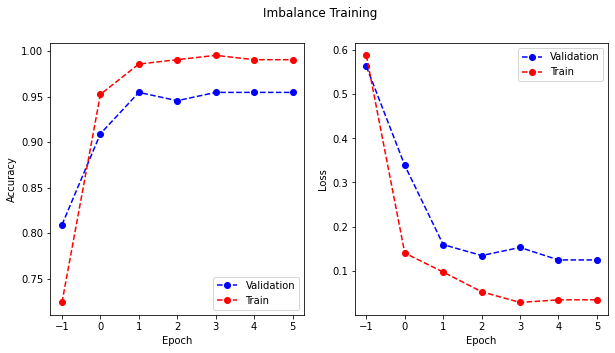

Finished Training


<Figure size 432x288 with 0 Axes>

Per-class accuracy:  [1.0, 0.5]
Precision:  1.0
Recall:  0.5
F1-score:  0.6666666666666666
Loading model...
Which epoch to load from? Choose from epochs below:
[0, 1, 2, 3, 4, 5]
Enter 0 to train from scratch.
>> 5
Loading from checkpoint checkpoints/imbalance_weighted/epoch=5.checkpoint.pth.tar
=> Successfully restored checkpoint (trained for 5 epochs)
Setting up interactive graph...
Epoch 5
	Validation Loss: 0.12327551427720622
	Validation Accuracy: 0.9636363636363636
	Train Loss: 0.05039005388971418
	Train Accuracy: 0.9857142857142858


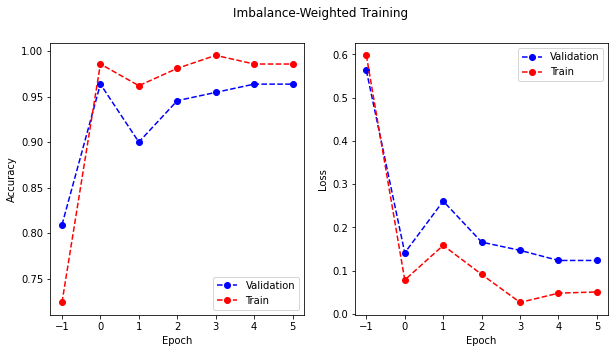

Finished Training


<Figure size 432x288 with 0 Axes>

Per-class accuracy:  [0.98, 0.8]
Precision:  0.8
Recall:  0.8
F1-score:  0.8000000000000002


In [6]:
# EECS 545 Fall 2021
from dataset import DogCatDataset
from train import evaluate_loop, train
from transfer import load_pretrained

def per_class_accuracy(y_true, y_pred, num_classes=2):
    """
    Compute the per-class accuracy given true and predicted labels.
    Inputs:
        - y_true: true labels, tensor with shape=(num_examples)
        - y_pred: predicted labels, tensor with shape=(num_examples)
    Returns:
        - per_class_acc: per-class accuracy, list of floats
    """
    # 
    TP = 0
    FP = 0
    TN = 0 
    FN = 0

    nlabel0 = 0
    nlabel1 = 0

    # # TODO (part h): compute the per-class accuracy
    for ii in range(y_true.shape[0]):
        if (y_true[ii] == 1):
            nlabel1 += 1
            if (y_pred[ii] == 1):
                TP += 1
            else:
                FN +=1 
        else:
            nlabel0 += 1
            if (y_pred[ii] == 1):
                FP += 1
            else:
                TN +=1
     
    return [TN/nlabel0, TP/nlabel1]


def precision(y_true, y_pred):
    """
    Compute the precision given true and predicted labels. Treat the dog class (label=1) as the positive class.
    Precision = TP / (TP + FP)
    Inputs:
        - y_true: true labels, tensor with shape=(num_examples)
        - y_pred: predicted labels, tensor with shape=(num_examples)
    Returns:
        - prec: precision, float
    """
    # 
    TP = 0
    FP = 0
    TN = 0 
    FN = 0

    nlabel0 = 0
    nlabel1 = 0

    # # TODO (part h): compute the per-class accuracy
    for ii in range(y_true.shape[0]):
        if (y_true[ii] == 1):
            nlabel1 += 1
            if (y_pred[ii] == 1):
                TP += 1
            else:
                FN +=1 
        else:
            nlabel0 += 1
            if (y_pred[ii] == 1):
                FP += 1
            else:
                TN +=1
    return TP/(TP+FP)


def recall(y_true, y_pred):
    """
    Compute the recall given true and predicted labels. Treat the dog class (label=1) as the positive class.
    Recall = TP / (TP + FN)
    Inputs:
        - y_true: true labels, tensor with shape=(num_examples)
        - y_pred: predicted labels, tensor with shape=(num_examples)
    Returns:
        - rec: recall, float
    """
    # TODO (part h): compute the recall
    # 
    TP = 0
    FP = 0
    TN = 0 
    FN = 0

    nlabel0 = 0
    nlabel1 = 0

    # # TODO (part h): compute the per-class accuracy
    for ii in range(y_true.shape[0]):
        if (y_true[ii] == 1):
            nlabel1 += 1
            if (y_pred[ii] == 1):
                TP += 1
            else:
                FN +=1 
        else:
            nlabel0 += 1
            if (y_pred[ii] == 1):
                FP += 1
            else:
                TN +=1
    return TP/(TP+FN)


def f1_score(y_true, y_pred):
    """
    Compute the f1-score given true and predicted labels. Treat the dog class (label=1) as the positive class.
    F1-score = 2 * (Precision * Recall) / (Precision + Recall)
    Inputs:
        - y_true: true labels, tensor with shape=(num_examples)
        - y_pred: predicted labels, tensor with shape=(num_examples)
    Returns:
        - f1: f1-score, float
    """
    # TODO (part h): compute the f1-score
    P = precision(y_true,y_pred)
    R = recall(y_true, y_pred)
    return 2*(P*R)/(P+R)


def compute_metrics(dataset, model):
    y_true, y_pred, _ = evaluate_loop(dataset.val_loader, model)
    print('Per-class accuracy: ', per_class_accuracy(y_true, y_pred))
    print('Precision: ', precision(y_true, y_pred))
    print('Recall: ', recall(y_true, y_pred))
    print('F1-score: ', f1_score(y_true, y_pred))


if __name__ == '__main__':
    # model with normal cross-entropy loss
    config = {
        'dataset_path': 'data/images/dogs_vs_cats_imbalance',
        'batch_size': 4,
        'ckpt_force': True,
        'ckpt_path': 'checkpoints/imbalance',
        'plot_name': 'Imbalance',
        'num_epoch': 5,
        'learning_rate': 1e-3,
        'momentum': 0.9,
    }
    dataset = DogCatDataset(config['batch_size'], config['dataset_path'])
    model = load_pretrained(num_classes=2)
    train(config, dataset, model)
    compute_metrics(dataset, model)

    # model with weighted cross-entropy loss
    config = {
        'ckpt_path': 'checkpoints/imbalance_weighted',
        'plot_name': 'Imbalance-Weighted',
        'num_epoch': 5,
        'learning_rate': 1e-3,
        'momentum': 0.9,
        'use_weighted': True,
    }
    model_weighted = load_pretrained(num_classes=2)
    train(config, dataset, model_weighted)
    compute_metrics(dataset, model_weighted)
